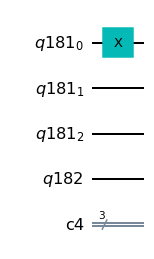

In [9]:
import os
import math 

from getpass import getpass
from coreapi.auth import BasicAuthentication
from qiskit import BasicAer, execute
from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit

from quantuminspire.credentials import get_authentication
from quantuminspire.qiskit import QI
from qiskit.circuit.library.standard_gates import PhaseGate
from qiskit.circuit.library.basis_change import QFT
import numpy as np
import matplotlib.pyplot as plt
import math

QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')

authentication = get_authentication()
QI.set_authentication(authentication, QI_URL)
qi_backend = QI.get_backend('QX single-node simulator')

q = QuantumRegister(3)
b = QuantumRegister(1)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, b, c)

qc.x(q[0])

qc.draw(output='mpl')

In [3]:
def increment(circuit, register, apply_QFT=True):
    q = register
    num = len(q)
    qc = circuit
    
    if apply_QFT == True:
        qc.barrier()
        qc = qc.compose(QFT(num_qubits=num, approximation_degree=0, do_swaps=True, \
                           inverse=False, insert_barriers=True, name='qft'))
        qc.barrier()
    
    for i, qubit in enumerate(q):
        qc.rz(math.pi/2**(num-1-i), qubit)
    
    if apply_QFT == True:
        qc.barrier()
        qc = qc.compose(QFT(num_qubits=num, approximation_degree=0, do_swaps=True, \
                          inverse=True, insert_barriers=True, name='iqft'))
        qc.barrier()
    
    return qc
    

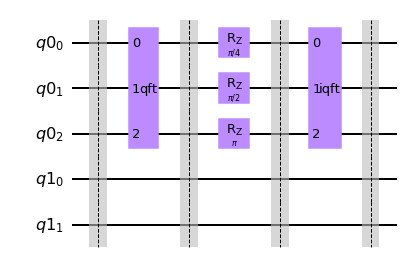

In [3]:
test = increment(qc, q)
test.draw(output='mpl')

In [13]:
def control_increment(circuit, qregister, cregister, apply_QFT=True):
    q = qregister
    c = cregister
    numq = len(q)
    numc = len(c)
    qc = circuit
    if apply_QFT == True:
        qc.barrier()
        qc = qc.compose(QFT(num_qubits=numq, approximation_degree=0, do_swaps=True, \
                            inverse=False, insert_barriers=True, name='qft'))
        qc.barrier()
    
    for i, qubit in enumerate(q):
        ncp = PhaseGate(math.pi/2**(numq-i-1)).control(numc)
        qc.append(ncp, [*c, qubit])
        
    if apply_QFT == True:
        qc.barrier() 
        qc = qc.compose(QFT(num_qubits=numq, approximation_degree=0, do_swaps=True, \
                            inverse=True, insert_barriers=True, name='iqft'))
        qc.barrier()
    return qc

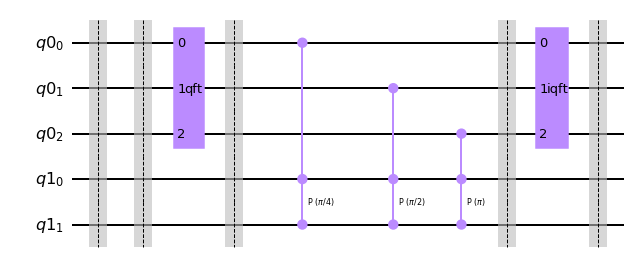

In [5]:
test2 = control_increment(qc, q, b)
test2.draw(output='mpl')


Result from the remote Quantum Inspire backend:

State	Counts
010	1024

Result from the local Qiskit simulator backend:

{'010': 1024}


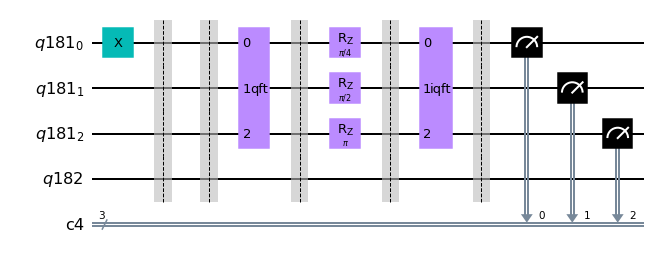

In [11]:
## Test increment without control
test = increment(qc, q)

test.measure(q[:], c[:])

qi_job = execute(test, backend=qi_backend, shots=1024)
qi_result = qi_job.result()
histogram = qi_result.get_counts(test)
print("\nResult from the remote Quantum Inspire backend:\n")
print('State\tCounts')
[print('{0}\t{1}'.format(state, counts)) for state, counts in histogram.items()]

print("\nResult from the local Qiskit simulator backend:\n")
backend = BasicAer.get_backend("qasm_simulator")
job = execute(test, backend=backend, shots=1024)
result = job.result()
print(result.get_counts(test))

test.draw(output='mpl')


Result from the remote Quantum Inspire backend:

State	Counts
010	1024

Result from the local Qiskit simulator backend:

{'010': 1024}


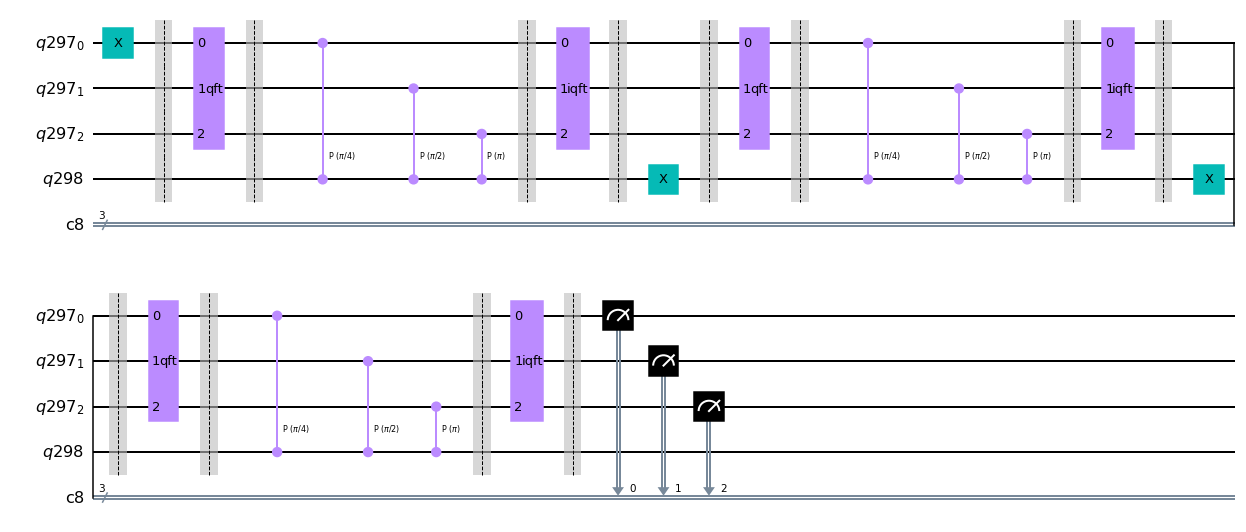

In [16]:
# Test control increment

q = QuantumRegister(3)
b = QuantumRegister(1)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, b, c)

qc.x(q[0])

qc = control_increment(qc, q, b)

# Flipping control qubit to 1
qc.x(b[0])

qc = control_increment(qc, q, b)

# Flipping control qubit to 1
qc.x(b[0])

qc = control_increment(qc, q, b)

# Should equal 010
qc.measure(q[:], c[:])

qi_job = execute(qc, backend=qi_backend, shots=1024)
qi_result = qi_job.result()
histogram = qi_result.get_counts(qc)
print("\nResult from the remote Quantum Inspire backend:\n")
print('State\tCounts')
[print('{0}\t{1}'.format(state, counts)) for state, counts in histogram.items()]

print("\nResult from the local Qiskit simulator backend:\n")
backend = BasicAer.get_backend("qasm_simulator")
job = execute(qc, backend=backend, shots=1024)
result = job.result()
print(result.get_counts(qc))
qc.draw(output="mpl")